In [3]:
import pandas as pd
import json
import h5py

import prediction
from pathlib import Path
from sklearn.preprocessing import StandardScaler

from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cpu


In [138]:
train_unfiltered_json = './data/Markus_trainsets/unfiltered.json'
train_unfiltered_tsv = './data/Markus_trainsets/unfiltered_rest_clu.tsv'

train_tolerant_json = './data/Markus_trainsets/tolerant.json'
train_tolerant_tsv = './data/Markus_trainsets/tolerant_rest_clu.tsv'

train_moderate_json = './data/Markus_trainsets/moderate.json'
train_moderate_tsv = './data/Markus_trainsets/moderate_rest_clu.tsv'

train_strict_json = './data/Markus_trainsets/strict.json'
train_strict_tsv = './data/Markus_trainsets/strict_rest_clu.tsv'

validation_fasta = './data/Markus_trainsets/rr_CheZOD117_test_set.fasta'
test_fasta = './data/Markus_trainsets/TriZOD_test_set.fasta'

h5_file = './data/BMRB_unfiltered_all.h5'

output = "./data/Markus_trainsets/Markus_trainsets_plots/"

In [3]:
h5_prost = "./data/Markus_trainsets/adel_bmrb_all_unfiltered_3Di.h5"

In [140]:
# Hyper parameters
num_epochs    = 1
learning_rate = 1e-3
batch_size    = 128 

# Initialize the model
input_dim = 1024 #1024  # Number of input features
output_dim = 2  # Number of output values
hidden_dim = 513  # Number of neurons in the hidden layer: (input_dim + output_dim) / 2,

#todo:try hidden_dim=32
model_choice = "FNN" 

In [122]:
def read_json(f, id1, id2):
    dict_list = []
    IDs = []
    dict_list_id1 = []
    dict_list_id2 = []
    
    with open(f,'r') as file:
        for line in file:
            line = line.replace('null','-100.0')
            d = json.loads(line)
            ID = d['ID']
            #sort ids by validation/test/train
            if ID in id1:
                dict_list_id1.append(d)
                continue
            if ID in id2:
                dict_list_id2.append(d)
                continue
            else:    
                IDs.append(ID)
                dict_list.append(d)
            
    return dict_list, IDs, dict_list_id1, dict_list_id2


def read_h5(h5_file):
    h5 = h5py.File(h5_file, 'r')

    # List all groups
    key_list = list(h5.keys())

    # Get the data
    dct = {}
    for key in key_list:
        emb = h5[key][:]
        dct[key] = emb   
    
    h5.close()
    return dct



def read_tsv(file):
    df = pd.read_csv(file, sep='\t',header=None)
    return df[0].unique()



def collect_non_null_shifts(tuple_list):
    no100 = []
    index = {} 
    counter = 0
    for i,tpl in enumerate(tuple_list):
        if -100.0 not in tpl:
            no100.append(tpl)
            index[i] = counter
            counter+=1
            
    return no100, index



def get_ids(fasta):
    ids = []
    
    with open(fasta,'r') as file:
        for line in file:
            if line.startswith(">"):
                ids.append(line[1:-1]) 
    return ids




def get_loaderset(json_dct_list, IDS, cluster_rep, embeddings, set_type, filtering):
    
    print("\n"+set_type)
    
    shift_list = []
    hn_all = []
    hn_no100_all = []
    index_no_100_all = []
    
    
    counter_shifts = 0
    counter_shifts_less20 = 0
    seq_len = 0
    seq_len_less20 = 0
    
    all_counter = 0
    filter1 = 0
    filter2 = 0
    filter3 = 0
    
    all_residues = 0
    filter1_residues = 0
    filter2_residues = 0
    filter3_residues = 0
    
    
    invalid_shifts = []
    
    
    #get data of cluster representatives
    for i ,e in enumerate(IDS):
        if e in cluster_rep:
            info = json_dct_list[i]
            
            seq = info.get('seq')
            prot_len = len(seq)
            
            
            h = info.get('H')
            n = info.get('N')
            hn = list(zip(h,n))
            
            #collect all non-null shifts as tuple_list and index_dictionary 
            no100, _ = collect_non_null_shifts(hn)
            len_no100 = len(no100)

            #collect % of invalid shifts/protein_length
            invalid = (prot_len-len_no100)/prot_len 
            # Pre-Filter: Entries without H/N shifts
            if invalid == 1.:
                continue
            
            
            #count residues/proteins
            all_counter += 1
            all_residues += prot_len
            
            if filtering:
            
                # 1.Filtering: more than 30% X in sequence are out
                cut_off_30_x = prot_len*0.3
                x = seq.count('X')

                if x > cut_off_30_x:
                    filter1 += 1
                    filter1_residues += prot_len
                    continue

                # 2.Filtering: less than 90% valid shifts are out (max. 10% null-shifts)
                cut_off_90_valid = prot_len*0.9
                if len_no100 < cut_off_90_valid:
                    filter2 += 1
                    filter2_residues += prot_len
                    continue

                #collect % of invalid shifts/protein_length
                invalid_shifts.append(invalid)

                # 3.Filtering: less than 20AAs are out 
                #Todo: try 30
                if prot_len < 30:
                    seq_len_less20 += 1
                    filter3 += 1
                    filter3_residues += prot_len
                    continue
                else:
                    seq_len += 1



                # 4.Filtering: outlier shifts set to null
                #filter out outliers if H>=5. and H<= 12. & N>=95. and N<=140.
                h_outliers_out = [i if i<=12. and i>=5. else -100.0 for i in h]
                n_outliers_out = [i if i<=140. and i>=95. else -100.0 for i in n]
                hn = list(zip(h_outliers_out,n_outliers_out))

                

            #collect all non-null shifts as tuple_list and index_dictionary 
            no100, index = collect_non_null_shifts(hn)
            
            if len(no100) == 0:
                continue
                  
            #collect data
            shift_list.append(info)   
            hn_no100_all.append(no100)
            hn_all.append(hn)
            index_no_100_all.append(index)
            
            
    f1 = all_counter-filter1
    f2 = f1-filter2
    f3 = f2-filter3
    
    f1_r = all_residues-filter1_residues
    f2_r = f1_r - filter2_residues
    f3_r = f2_r - filter3_residues
    
    print("all proteins: "+str(all_counter))
    print("filter1: "+str(f1))
    print("filter2: "+str(f2))
    print("filter3: "+str(f3))
    
    print("\nall residues: "+str(all_residues))
    print("filter1: "+str(f1_r))
    print("filter2: "+str(f2_r))
    print("filter3: "+str(f3_r))
    
    
    #flatten list
    flat_hn = [item for sublist in hn_no100_all for item in sublist]
    
    #get mean of hn
    scaler = StandardScaler()
    scaler.fit(flat_hn)
    mean = scaler.mean_
    #print(set_type)
    print(mean)
    
    
    dct = {}
    hn_all2 = []
    
    for i,entry in enumerate(shift_list):
        hn = hn_all[i]
        hn_no100 = hn_no100_all[i]
        index_no100 = index_no_100_all[i]
        
        
        
        hn_no100_scale = scaler.transform(hn_no100).tolist()
        hn = [[-100.0,-100.0] if -100.0 in tpl else hn_no100_scale[index_no100.get(i)] for i, tpl in enumerate(hn)]
        
        seq = entry.get('seq')
        ID = entry.get('ID')
        emb = embeddings.get(ID)
        if emb is None:
            #print("no emb")
            continue
        
        dct[seq] = [(ID,emb,hn)]
        hn_all2.extend(hn_no100)
        
    if len(invalid_shifts) != 0:
        return dct, hn_all2, invalid_shifts, [all_counter,f1,f2,f3], [all_residues,f1_r,f2_r,f3_r]
    else:
        return dct, hn_all2
    



def get_mean(l):
    return sum(l)/len(l)

def get_std(l):
    return np.std(l)


In [7]:
embeddings = read_h5(h5_file)

In [7]:
prost_emb = read_h5(h5_prost)

In [8]:
emb = {}

for k,v in prost_emb.items():
    k = k[:-4]
    if k in embeddings:
        d2 = embeddings[k]
        if len(d2) == len(v):
            e = np.concatenate((d2, v), axis=1)
            emb[k] = e
        #else:
        #    print(k)

10001_1_1_1
1065_1_1_1
1071_1_1_1
1095_1_1_1
11005_1_1_1
11006_1_1_1
11058_1_1_1
11059_1_1_1
11115_1_2_2
11434_1_1_1
11436_1_1_1
1144_1_1_1
1145_1_1_1
11463_1_1_1
11496_2_2_2
114_1_1_1
11504_1_2_2
11508_1_2_2
1152_1_1_1
11538_1_1_1
11539_1_1_1
1153_1_1_1
11543_1_1_1
1154_1_1_1
11551_1_1_1
11552_1_1_1
11553_1_1_1
11554_1_1_1
1155_1_1_1
11578_1_1_1
11605_1_1_1
11606_1_1_1
11606_2_2_2
1170_1_1_1
1171_1_1_1
1192_1_1_1
1194_1_1_1
12019_1_1_1
12021_1_1_1
1204_1_1_1
1207_1_1_1
1208_1_1_1
1230_1_1_1
126_1_1_1
131_1_1_1
133_1_1_1
1393_1_1_1
1394_1_1_1
139_1_1_1
1403_1_1_1
1404_1_1_1
142_1_1_1
1445_1_1_1
1446_1_1_1
144_1_1_1
146_1_1_1
1481_1_1_1
1482_1_1_1
15000_1_1_1
15031_1_1_1
15040_1_1_1
15041_1_1_1
15042_1_1_1
15043_1_1_1
15044_1_1_1
15050_1_1_1
15051_1_1_1
15056_1_1_1
15068_1_1_1
15069_1_1_1
15122_1_1_1
15145_1_1_1
15159_1_1_1
15174_1_1_1
15175_1_1_1
1518_1_1_1
1519_1_1_1
1520_1_1_1
15241_1_1_1
15241_1_2_1
15272_1_1_1
15273_1_1_1
15282_1_1_1
15284_1_1_1
15285_1_1_1
15287_1_1_1
15291_1_1_1


30479_1_1_1
30482_1_1_1
30483_1_1_1
30486_1_1_1
30487_1_1_1
30488_1_1_1
30489_1_1_1
30490_1_1_1
30496_1_1_1
30497_1_1_1
30498_1_1_1
30499_1_1_1
30502_1_2_2
30516_1_1_1
30519_1_1_1
30524_1_1_1
30534_1_1_1
30535_1_1_1
30536_1_1_1
30544_1_1_1
30557_1_1_1
30558_1_1_1
30585_1_2_2
30594_1_1_1
30595_1_1_1
30601_1_1_1
30617_1_1_1
30618_1_1_1
30630_1_1_1
30631_1_1_1
30641_1_1_1
30642_1_1_1
30643_1_1_1
30644_1_1_1
30673_1_1_1
30674_1_1_1
30683_1_1_1
30690_1_1_1
30692_1_1_1
30702_1_1_1
30710_1_1_1
30712_1_1_1
30713_1_1_1
30714_1_1_1
30716_1_1_1
30718_1_1_1
30727_1_1_1
30728_1_1_1
30729_1_1_1
30738_1_1_1
30744_1_1_1
30745_1_1_1
30746_1_1_1
30748_1_1_1
30749_1_1_1
30750_1_1_1
30752_1_1_1
30758_1_1_1
30767_1_1_1
30775_1_1_1
30776_1_1_1
30778_1_1_1
30789_1_1_1
30793_1_1_1
30811_1_1_1
30826_1_1_1
30839_1_1_1
30840_1_1_1
30864_1_1_1
30872_1_1_1
30873_1_1_1
30888_1_1_1
30891_1_1_1
30892_1_1_1
30893_1_1_1
30894_1_1_1
30895_1_1_1
30896_1_1_1
308_1_1_1
30900_1_1_1
30903_1_1_1
30915_1_1_1
30916_1_1_1
30917_

In [9]:
embeddings = emb

In [123]:
#Train Set 
cluster_rep_unfiltered = read_tsv(train_unfiltered_tsv)
cluster_rep_tolerant = read_tsv(train_tolerant_tsv)
cluster_rep_moderate = read_tsv(train_moderate_tsv)
cluster_rep_strict = read_tsv(train_strict_tsv)


#get ids of validation and test set from fasta
validation_ids = get_ids(validation_fasta)
test_ids = get_ids(test_fasta)


In [124]:
#redundancy reduction (Test and Validation Set) included
train_unfiltered_list, train_unfiltered_IDS, validation_list, test_list = read_json(train_unfiltered_json, validation_ids, test_ids)
train_tolerant_list, train_tolerant_IDS, _, _ = read_json(train_tolerant_json, validation_ids, test_ids)
train_moderate_list, train_moderate_IDS, _, _ = read_json(train_moderate_json, validation_ids, test_ids)
train_strict_list, train_strict_IDS, _, _ = read_json(train_strict_json, validation_ids, test_ids)


In [125]:
train_unfiltered,hn_unfiltered,invalid_shifts_unfiltered,p_u, r_u = get_loaderset(train_unfiltered_list, train_unfiltered_IDS, cluster_rep_unfiltered, embeddings, "Unfiltered", True)
train_tolerant,hn_tolerant,invalid_shifts_tolerant,p_t, r_t = get_loaderset(train_tolerant_list, train_tolerant_IDS, cluster_rep_tolerant, embeddings, "Tolerant", True)
train_moderate,hn_moderate,invalid_shifts_moderate, p_m, r_m = get_loaderset(train_moderate_list, train_moderate_IDS, cluster_rep_moderate, embeddings, "Moderate", True)
train_strict,hn_strict,invalid_shifts_strict,p_s, r_s = get_loaderset(train_strict_list, train_strict_IDS, cluster_rep_strict, embeddings, "Strict", True)


valid,hn_valid,_,_,_ = get_loaderset(validation_list, validation_ids, validation_ids, embeddings, "Validation", True)
test,hn_test,_,_,_ = get_loaderset(test_list, test_ids, test_ids, embeddings, "Test", True)




Unfiltered
all proteins: 5876
filter1: 5848
filter2: 5848
filter3: 5538

all residues: 690803
filter1: 690051
filter2: 690051
filter3: 684086
[  8.26330186 119.51449227]

Tolerant
all proteins: 5663
filter1: 5663
filter2: 5663
filter3: 5371

all residues: 665583
filter1: 665583
filter2: 665583
filter3: 659829
[  8.26417818 119.51278639]

Moderate
all proteins: 4628
filter1: 4628
filter2: 4628
filter3: 4424

all residues: 528387
filter1: 528387
filter2: 528387
filter3: 524065
[  8.27492425 119.50988803]

Strict
all proteins: 990
filter1: 990
filter2: 990
filter3: 966

all residues: 114555
filter1: 114555
filter2: 114555
filter3: 114025
[  8.27206517 119.51347758]

Validation
all proteins: 107
filter1: 107
filter2: 107
filter3: 107

all residues: 12908
filter1: 12908
filter2: 12908
filter3: 12908
[  8.24539932 119.89684269]

Test
all proteins: 339
filter1: 339
filter2: 339
filter3: 330

all residues: 38106
filter1: 38106
filter2: 38106
filter3: 37903
[  8.26750067 119.55052726]


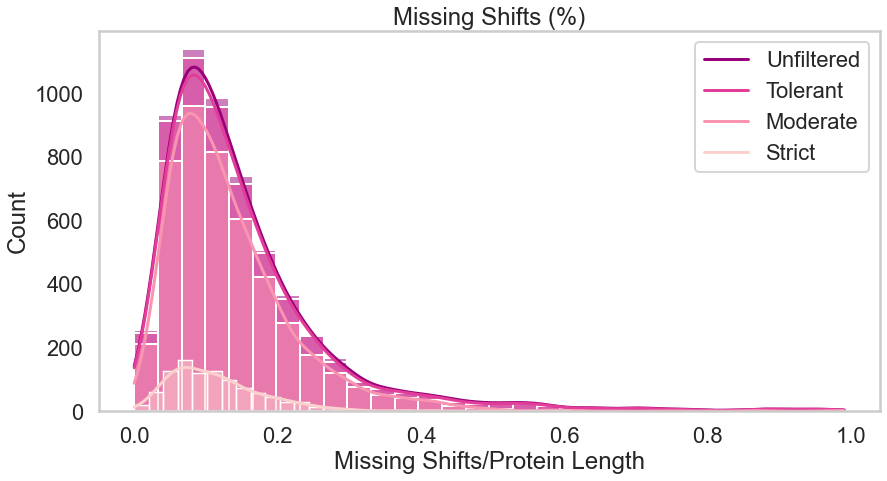

In [127]:
def missing_shifts_plot(colours):
    plt.figure(figsize=(14, 7))
    plt.rcParams.update({'font.size': 20})
    sns.set(font_scale=2)
    sns.set_context("poster")
    
    sns.set_style("whitegrid", {'axes.grid' : False, "grid.color": "1", "grid.linestyle": ":"})
    sns.despine(bottom = False, left = False)

    sns.histplot(invalid_shifts_unfiltered,bins=30,kde=True,
                  color = colours[0],fill=True)
    
    sns.histplot(invalid_shifts_tolerant,bins=30,kde=True, 
                  color = colours[1],fill=True)
    
    sns.histplot(invalid_shifts_moderate, bins=30,kde=True,
                 color = colours[2],fill=True)
    
    sns.histplot(invalid_shifts_strict,bins=30,kde=True,
                 color = colours[3],fill=True)
    
    

    plt.legend(['Unfiltered', 'Tolerant', 'Moderate', 'Strict'])
    plt.title("Missing Shifts (%)")
    plt.xlabel('Missing Shifts/Protein Length')

    plt.savefig(output+'invalid_shifts_30.png',bbox_inches='tight',dpi=300)

missing_shifts_plot(colours)

In [93]:
# Choose a Seaborn color palette
palette = sns.color_palette("RdPu",4)[::-1]

# Select four colors from the palette
colours = palette[:4]


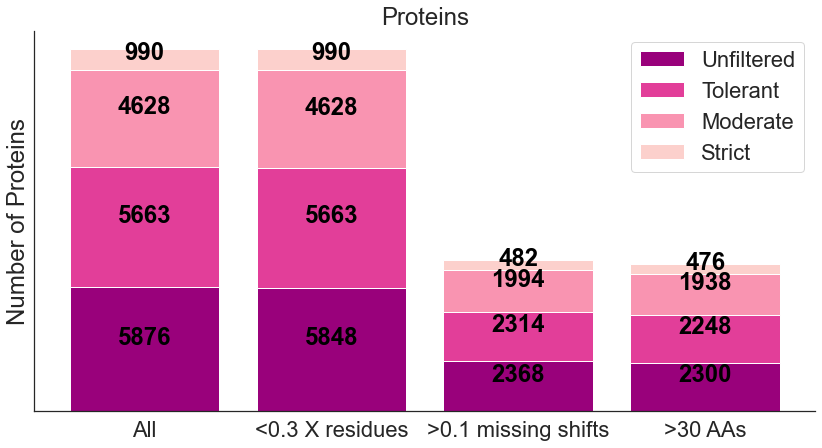

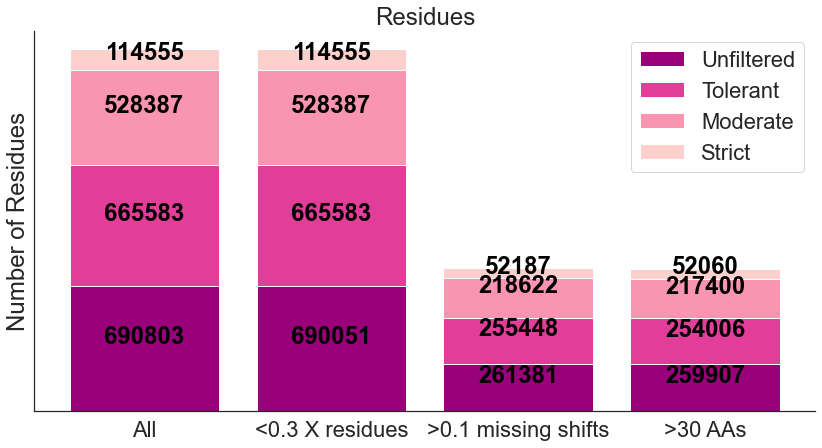

In [121]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
        num = round(num, -1)
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

def plot_filtering(y1, y2, y3, y4, y_label,outname, title, colours):

    plt.rcParams.update({'font.size': 18})
    sns.set(font_scale=2)
    
    
    sns.set_style("white", {'axes.grid' : False})
    #sns.despine(bottom = False, left = False)
    

    # create data
    x = ['All', '<0.3 X residues', '>0.1 missing shifts', '>30 AAs']
    

    fig, ax = plt.subplots(figsize =(14, 7))
    #colours = [(0.4980392156862745, 0.788235294117647, 0.4980392156862745), (0.7450980392156863, 0.6823529411764706, 0.8313725490196079), (0.9921568627450981, 0.7529411764705882, 0.5254901960784314), (1.0, 1.0, 0.6)]
    # plot bars in stack manner
    ax1 = ax.bar(x, y1, color=colours[0])#'teal')
    ax2 = ax.bar(x, y2, bottom=y1, color=colours[1])#'blueviolet')
    ax3 = ax.bar(x, y3, bottom=y1+y2, color=colours[2])#'lightskyblue')
    ax4 = ax.bar(x, y4, bottom=y1+y2+y3, color=colours[3])#'magenta')
    #plt.xlabel("Teams")
    ax.set_yticks([])
    plt.ylabel(y_label)
    plt.legend(['Unfiltered', 'Tolerant', 'Moderate', 'Strict'])
    plt.title(title)
    sns.despine()

    for r1, r2,r3, r4 in zip(ax1, ax2, ax3, ax4):
        h1 = r1.get_height()
        h2 = r2.get_height()
        h3 = r3.get_height()
        h4 = r4.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2.,"%d" % round(h1, 0) , ha="center", va="bottom", color="black",fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % round(h2, 0), ha="center", va="bottom", color="black",fontweight="bold")
        plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2+h3 / 2., "%d" % round(h3, 0), ha="center", va="bottom", color="black",fontweight="bold")
        plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2+h3+h4 / 2., "%d" % round(h4, 0), ha="center", va="baseline", color="black",fontweight="bold")
        #"%d" % round(h1, -1)
        #human_format(h1)
    plt.savefig(output+outname+'_plain_30.png',bbox_inches='tight',dpi=300)

    plt.show()
    
#plot #proteins    
y1 = np.array(p_u)
y2 = np.array(p_t)
y3 = np.array(p_m)
y4 = np.array(p_s)
plot_filtering(y1, y2, y3, y4, "Number of Proteins","filtering_proteins", "Proteins", colours)

#plot #residues
y1 = np.array(r_u)
y2 = np.array(r_t)
y3 = np.array(r_m)
y4 = np.array(r_s)
plot_filtering(y1, y2, y3, y4, "Number of Residues","filtering_residues","Residues", colours)

In [46]:
def plot1():
    # create data
    x = ['Unfiltered', 'Tolerant', 'Moderate', 'Strict']
    y1 = np.array([1705,1397,766, 11])
    y2 = np.array([ 4618, 4452, 3512, 489])

    fig, ax = plt.subplots(figsize =(14, 7))

    # plot bars in stack manner
    ax1 = ax.bar(x, y1, color='orange')
    ax2 = ax.bar(x, y2, bottom=y1, color='b')
    #plt.bar(x, y3, bottom=y1+y2, color='y')
    #plt.bar(x, y4, bottom=y1+y2+y3, color='g')
    #plt.xlabel("Teams")
    plt.ylabel("Number of Shifts")
    plt.legend(["Less than 20 Valid Shifts", "More than 20 Valid Shifts"])
    plt.title("Shifts")

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")


    #plt.savefig(output+"shifts"+'.png',bbox_inches='tight')

    #plt.show()


In [15]:
def plot2():
    # create data
    x = ['Unfiltered', 'Tolerant', 'Moderate', 'Strict']
    y1 = np.array([760,622,284, 5])
    y2 = np.array([ 5563, 5227, 3994, 495])

    fig, ax = plt.subplots(figsize =(14, 7))

    # plot bars in stack manner
    ax1 = ax.bar(x, y1, color='orange')
    ax2 = ax.bar(x, y2, bottom=y1, color='b')
    #plt.bar(x, y3, bottom=y1+y2, color='y')
    #plt.bar(x, y4, bottom=y1+y2+y3, color='g')
    #plt.xlabel("Teams")
    plt.ylabel("Number of Sesquences")
    plt.legend(["Less than 20 AAs", "More than 20 AAs"])
    plt.title("Sequences")

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")


    #plt.savefig(output+"seqs"+'.png',bbox_inches='tight')

    #plt.show()

In [128]:
h_unfiltered,n_unfiltered = zip(*hn_unfiltered)
h_tolerant,n_tolerant = zip(*hn_tolerant)
h_moderate,n_moderate = zip(*hn_moderate)
h_test,n_test = zip(*hn_test)

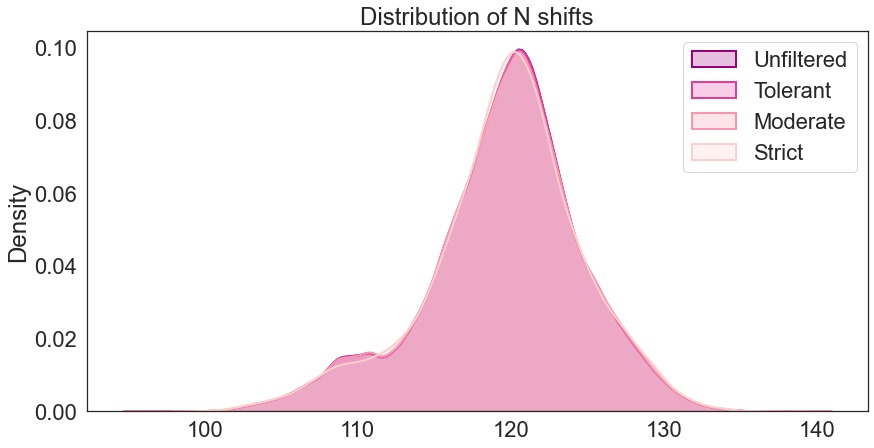

In [135]:
def plot_density(x1, x2, x3, x4,labels,title,model_choice,num_epochs,learning_rate,hidden_dim,output, colours):

    fig = plt.figure(figsize =(14, 7))
    sns.set(font_scale=2)
    sns.set_style("white", {'axes.grid' : False})


    # plotting both distibutions on the same figure
    fig = sns.kdeplot(x1,linewidth=2,color=colours[0],fill=True)
    fig = sns.kdeplot(x2,linewidth=2,color=colours[1],fill=True)
    fig = sns.kdeplot(x3,linewidth=2,color=colours[2],fill=True)
    fig = sns.kdeplot(x4,linewidth=2,color=colours[3],fill=True)
    
    #t = f'mean_unfiltered = {get_mean(x1):.2f}\nmean_tolerant = {get_mean(x2):.2f}\nmean_moderate = {get_mean(x3):.2f}\nmean_strict = {get_mean(x4):.2f}'
    #plt.text(5, 0.6, t, horizontalalignment='left', size='medium', color='black')
    #mean_x1 = get_mean(x1)
    #plt.axvline(x=mean_x1,color='red')

    plt.legend(labels)
    plt.title(title)

    plt.savefig(output+model_choice+'_'+str(num_epochs)+'_'+str(learning_rate)+'_'+str(hidden_dim)+'.png',bbox_inches='tight')
    plt.show()

    
labels=["Unfiltered","Tolerant","Moderate","Strict"]
# H-Shifts
title= "Distribution of H shifts"
#plot_density(h_unfiltered, h_tolerant, h_moderate, h_test,labels,title,model_choice,num_epochs,learning_rate,hidden_dim,output+"hdistribtion_", colours)


# N-Shifts
title= "Distribution of N shifts"
plot_density(n_unfiltered, n_tolerant, n_moderate, n_test,labels,title,model_choice,num_epochs,learning_rate,hidden_dim,output+"ndistribtion_",colours)


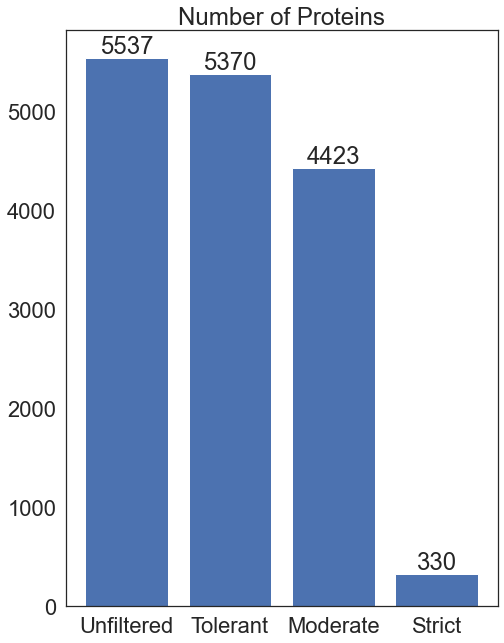

In [136]:
def get_number_proteins_barplot(data, labels,model_choice,num_epochs,learning_rate,hidden_dim,output):
    fig = plt.figure(figsize =(6, 8))
    ax = fig.add_axes([0,0,1,1])

    bars = ax.bar(labels,data)
    ax.bar_label(bars)
    ax.set_title('Number of Proteins')
    
    #plt.savefig(output+"proteins_"+model_choice+'_'+str(num_epochs)+'_'+str(learning_rate)+'_'+str(hidden_dim)+'.png',bbox_inches='tight')
    plt.show()

#data = [len(train_unfiltered),len(train_tolerant),len(train_moderate), len(test)]
#labels = ["Unfiltered","Tolerant","Moderate","Strict"]

#get_number_proteins_barplot(data, labels,model_choice,num_epochs,learning_rate,hidden_dim,output)

In [141]:
def get_boxplot_accuracy(data,labels,model,num_epochs,learning_rate,hidden_dim,output,train_type, colours):

    plt.rcParams.update({'font.size': 25})
    sns.set_style("white", {'axes.grid' : False})
    
    
    fig = plt.figure(figsize =(5, 7))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot(data,patch_artist=True)

    for patch, colour in zip(bp['boxes'], colours):
        patch.set_facecolor(colour)

    plt.title("Accuracy per Protein")
    ax.set_xticklabels(labels)

    # show plot
    plt.savefig(output+"accuracy_"+model+'_'+str(num_epochs)+'_'+str(learning_rate)+'_'+str(hidden_dim)+'_'+train_type+'.png',bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

# Model Prediction

In [20]:
def training_models():
    model_choice = "LinReg"
    acc_moderate_linreg, _, pears_moderate_linreg = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_moderate,valid,test,output+"moderate/","Moderate")
    model_choice = "FNN"
    acc_moderate_fnn, acc_rdnm, pears_moderate_fnn = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_moderate,valid,test,output+"moderate/","Moderate")
    model_choice = "CNN"
    acc_moderate_cnn, _1, pears_moderate_cnn = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_moderate,valid,test,output+"moderate/","Moderate")


    data = [['Linear Regression',round(get_mean(acc_moderate_linreg),2), round(get_std(acc_moderate_linreg),2),round(pears_moderate_linreg[0],2),round(pears_moderate_linreg[2],2)],
            ['FNN',round(get_mean(acc_moderate_fnn),2), round(get_std(acc_moderate_fnn),2),round(pears_moderate_fnn[0],2), round(pears_moderate_fnn[2],2)],
            ['CNN',round(get_mean(acc_moderate_cnn),2), round(get_std(acc_moderate_cnn),2),round(pears_moderate_cnn[0],2), round(pears_moderate_cnn[2],2)]]



    df = pd.DataFrame(data, columns=['Dataset', 'Mean of Accuracy', 'Stdv of Accuracy','Pearson Correlation (H)','Pearson Correlation (N)'])
    df.to_csv(output+"acc_pears_table_models_prostt5"+model_choice+'_'+str(num_epochs)+'_'+str(learning_rate)+'_'+str(hidden_dim)+".csv",index=False)
    df

    data = [acc_moderate_linreg, acc_moderate_fnn,acc_moderate_cnn, acc_rdnm]
    labels = ['Linear Regression','FNN','CNN','Random']
    colours = ['lightskyblue','lightskyblue','lightskyblue']
    get_boxplot_accuracy(data,labels,model_choice,num_epochs,learning_rate,hidden_dim,output,'prostt5')
    
training_models()

Number of free parameters: 526853
Unfiltered
Epoch [0/1], VALID loss: 0.25, Accuracy Mean: 0.01, Accuracy RNDM: 0.01
New best model found with loss= 0.251
Epoch [0/1], TRAIN loss: 0.15
Loaded model from epoch: 0.0
Running final evaluation on the best checkpoint.
Epoch [0/1], Test loss: 0.28, Accuracy Mean: 0.01, Accuracy RNDM: 0.01


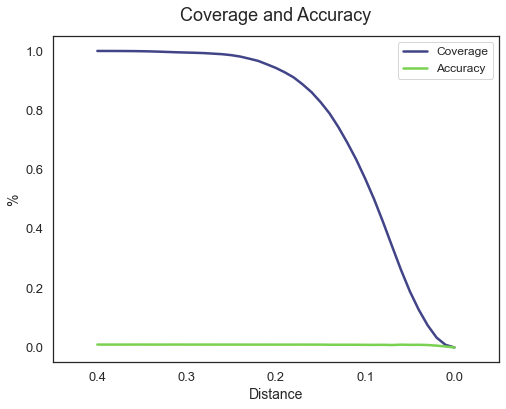

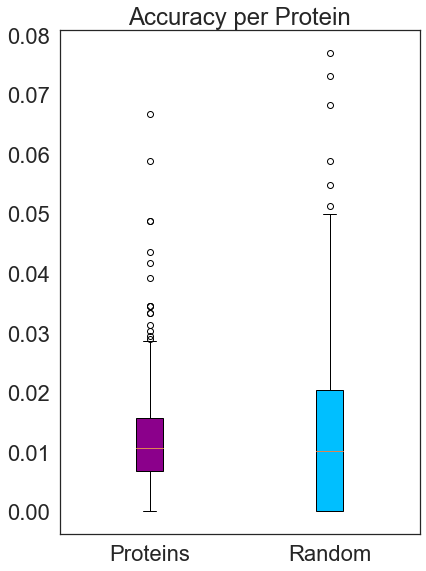

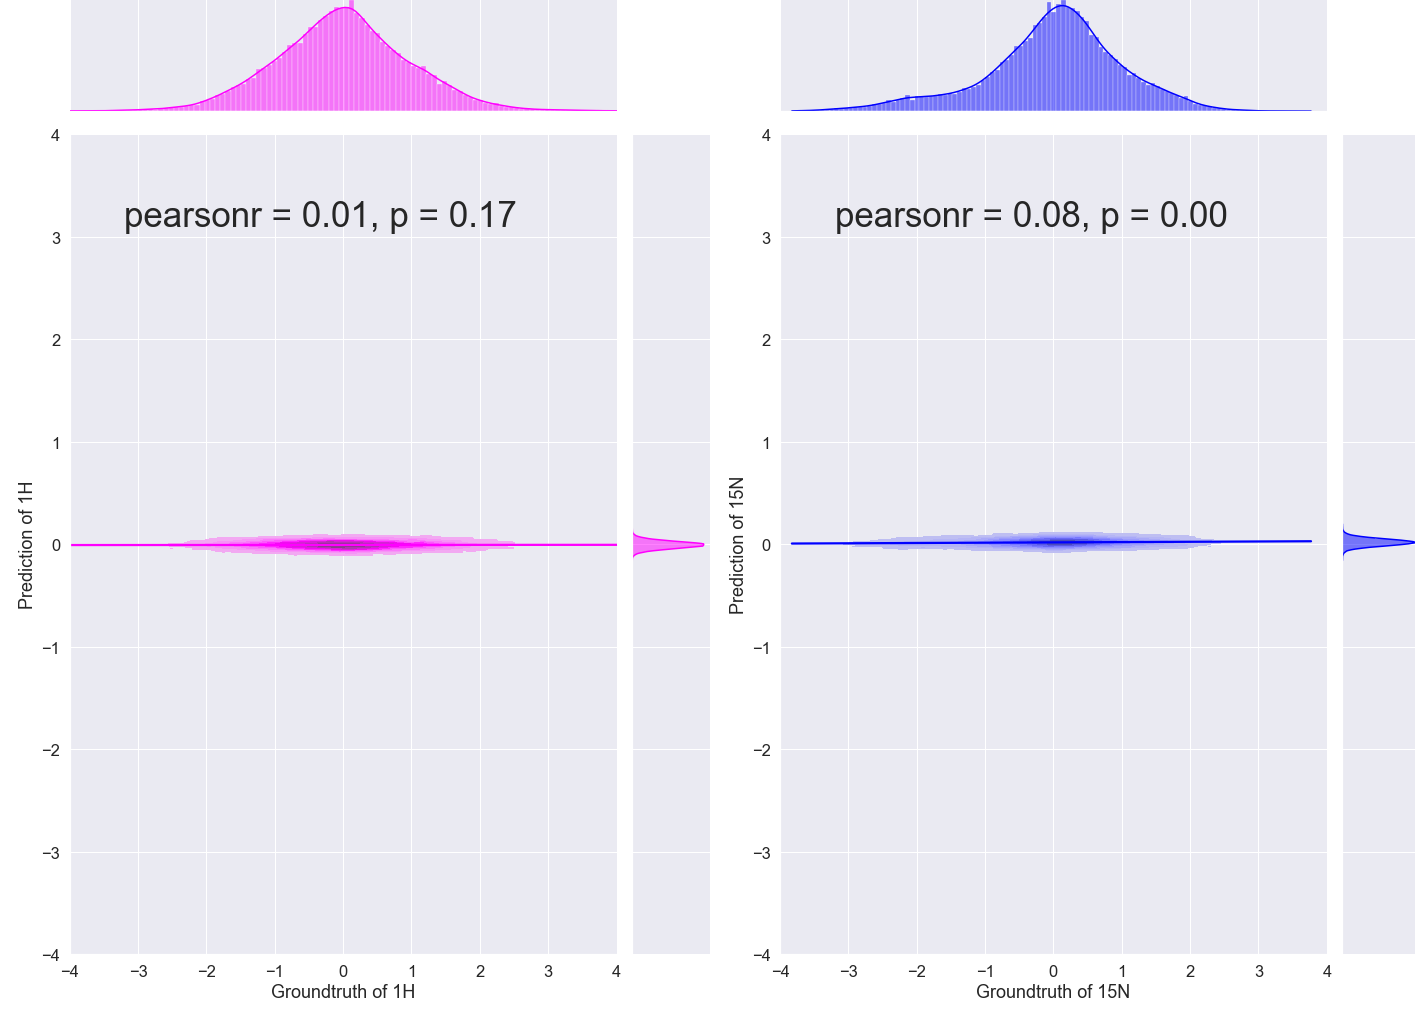

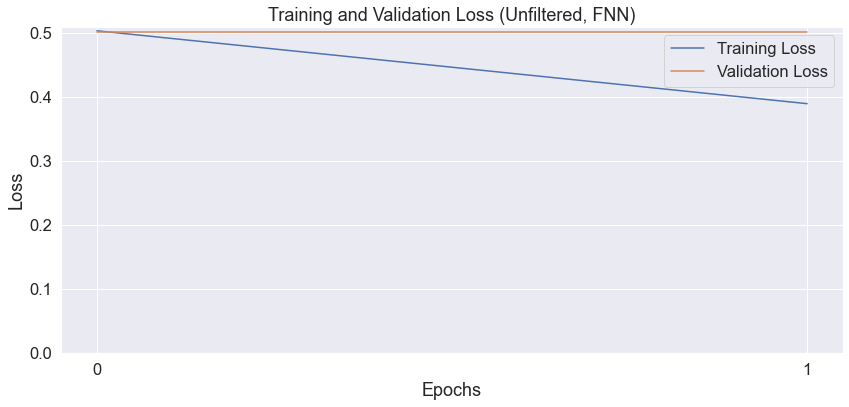

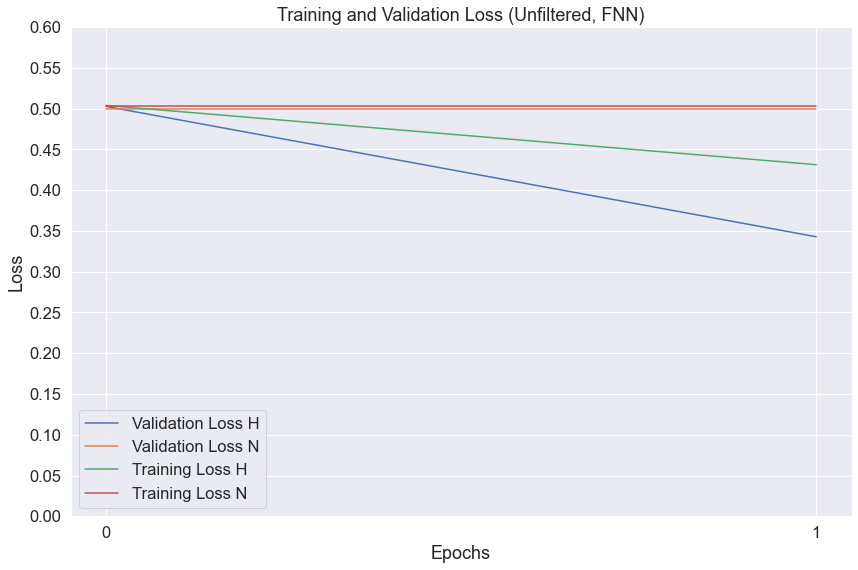

Number of free parameters: 526853
Tolerant
Epoch [0/1], VALID loss: 0.25, Accuracy Mean: 0.01, Accuracy RNDM: 0.01
New best model found with loss= 0.252
Epoch [0/1], TRAIN loss: 0.15
Loaded model from epoch: 0.0
Running final evaluation on the best checkpoint.
Epoch [0/1], Test loss: 0.27, Accuracy Mean: 0.01, Accuracy RNDM: 0.01


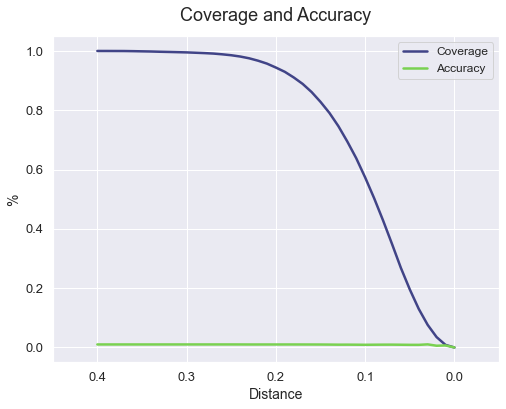

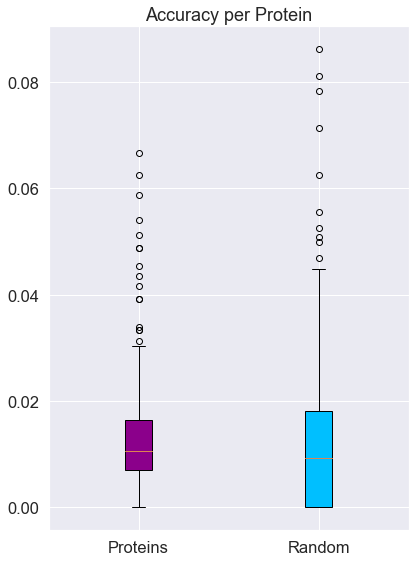

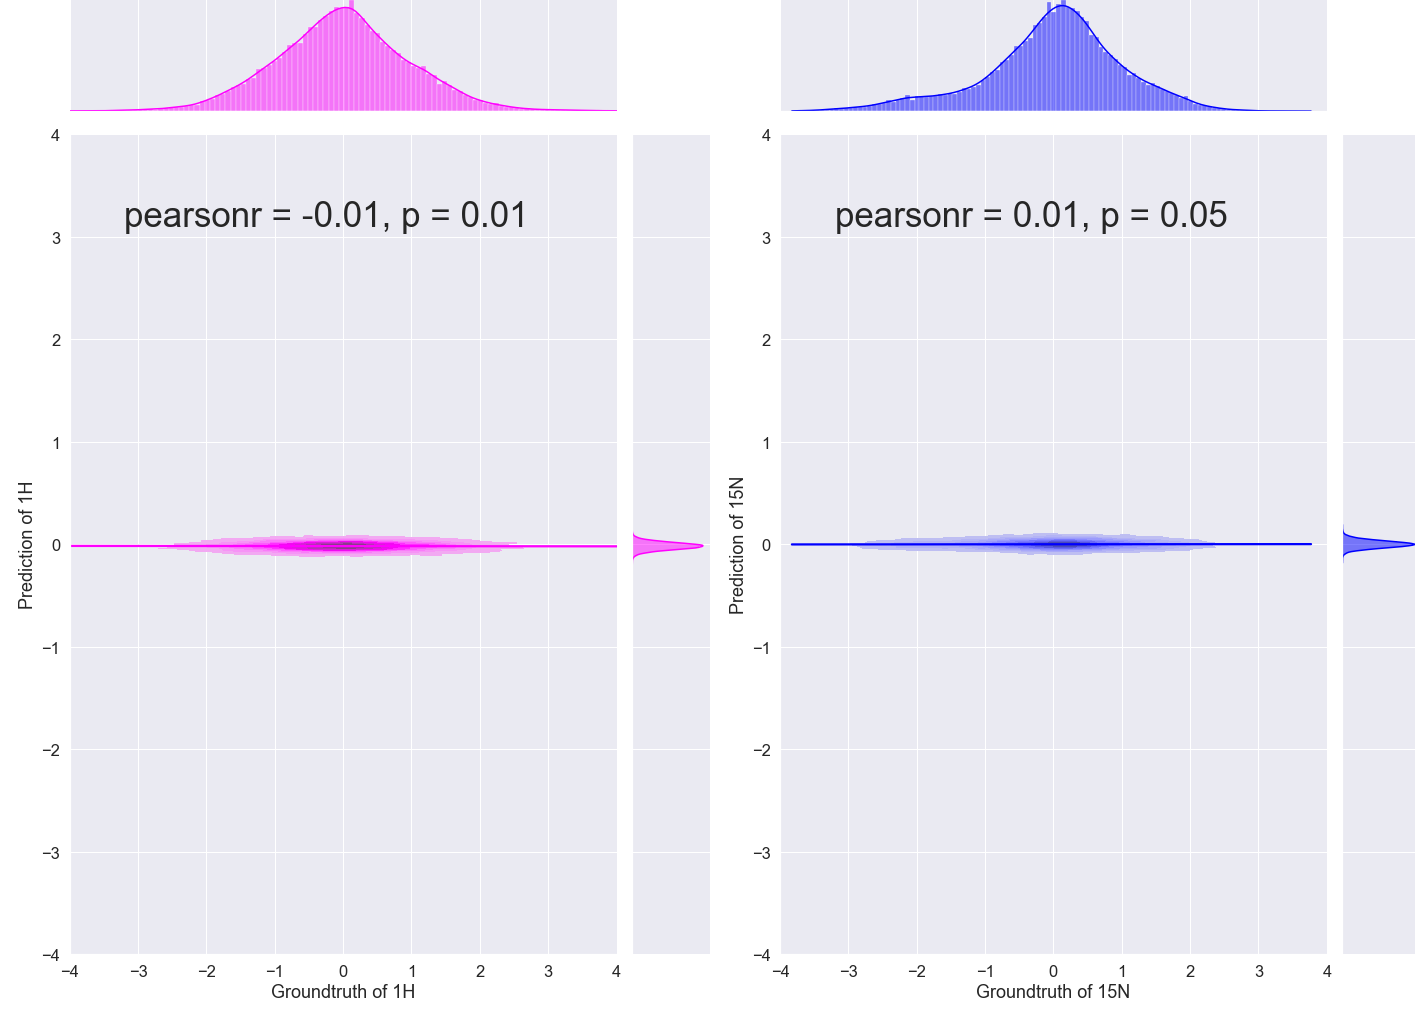

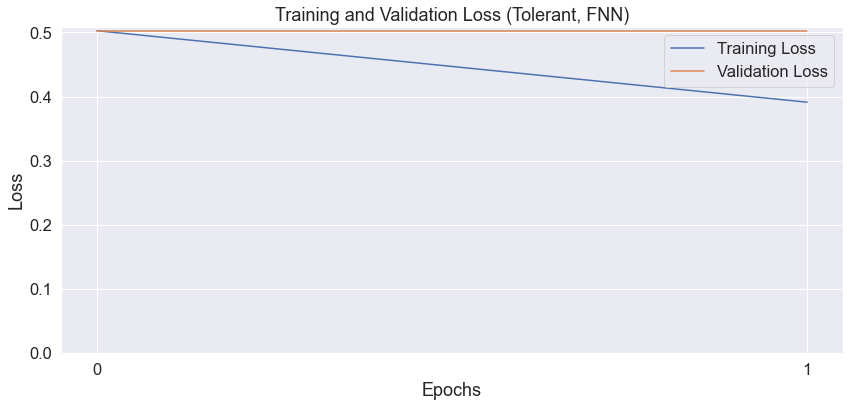

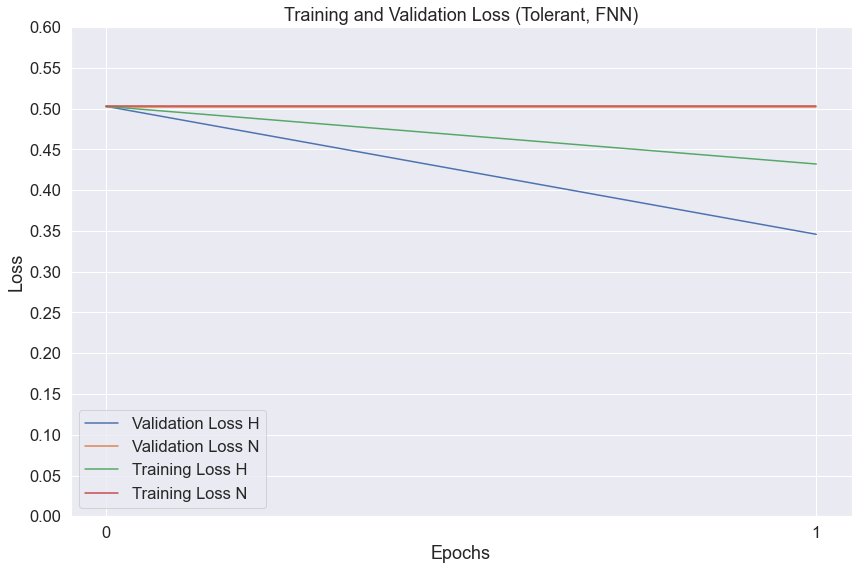

Number of free parameters: 526853
Moderate
Epoch [0/1], VALID loss: 0.25, Accuracy Mean: 0.01, Accuracy RNDM: 0.01
New best model found with loss= 0.252
Epoch [0/1], TRAIN loss: 0.17
Loaded model from epoch: 0.0
Running final evaluation on the best checkpoint.
Epoch [0/1], Test loss: 0.33, Accuracy Mean: 0.01, Accuracy RNDM: 0.01


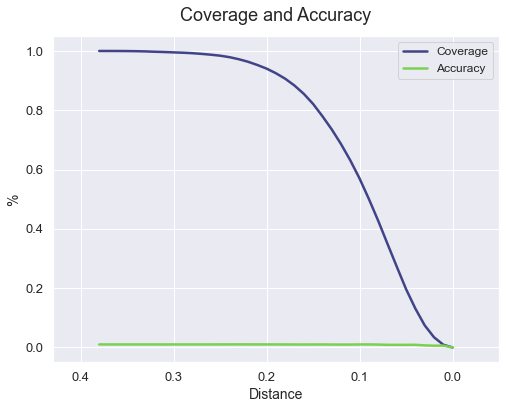

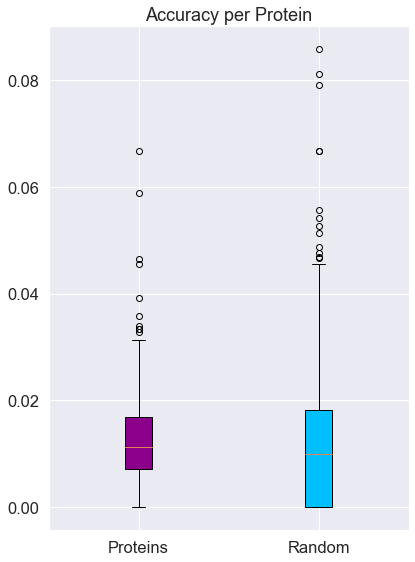

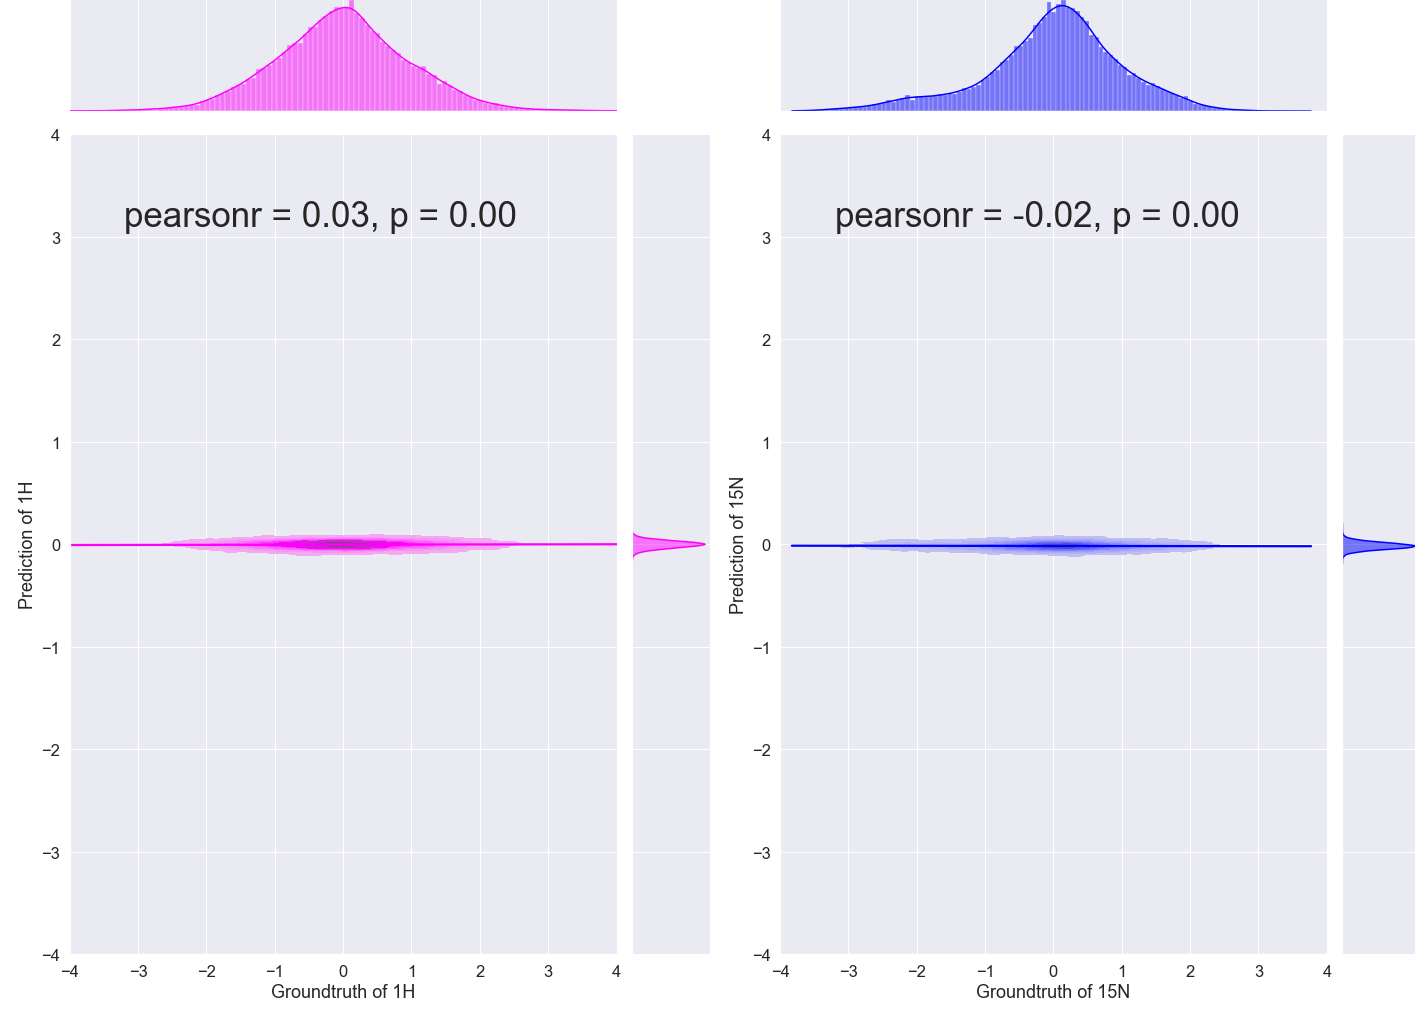

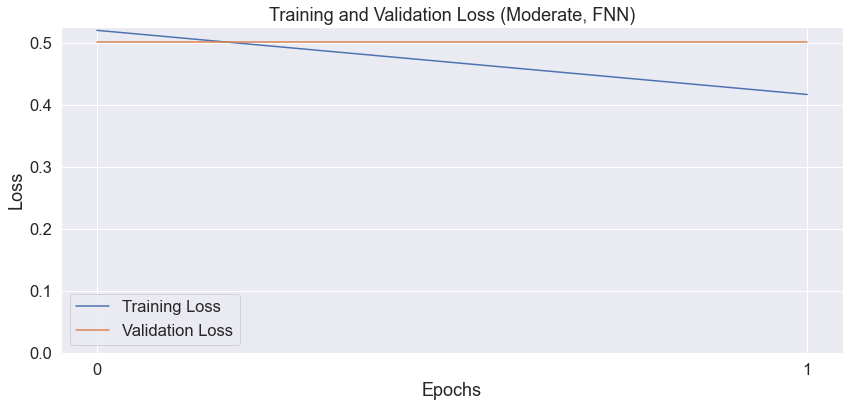

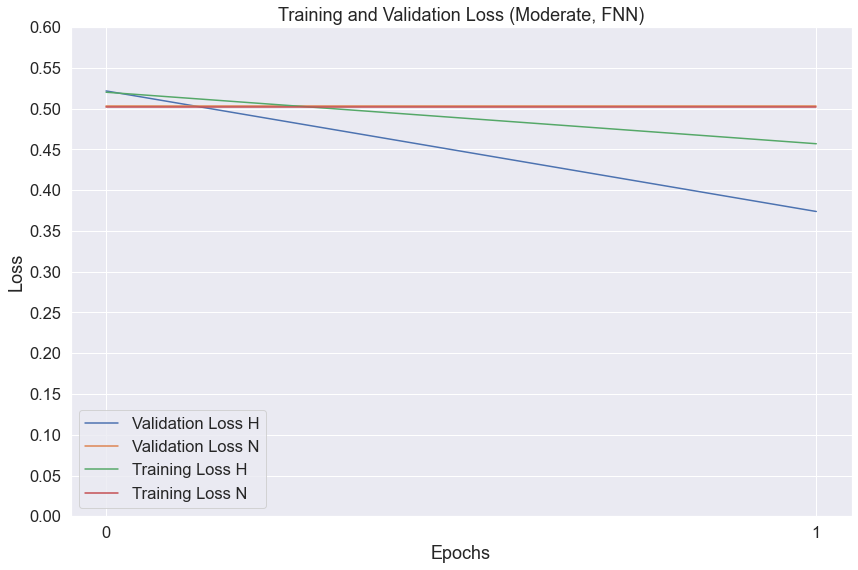

Number of free parameters: 526853
Strict
Epoch [0/1], VALID loss: 0.25, Accuracy Mean: 0.01, Accuracy RNDM: 0.01
New best model found with loss= 0.253
Epoch [0/1], TRAIN loss: 0.25
Loaded model from epoch: 0.0
Running final evaluation on the best checkpoint.
Epoch [0/1], Test loss: 0.27, Accuracy Mean: 0.01, Accuracy RNDM: 0.01


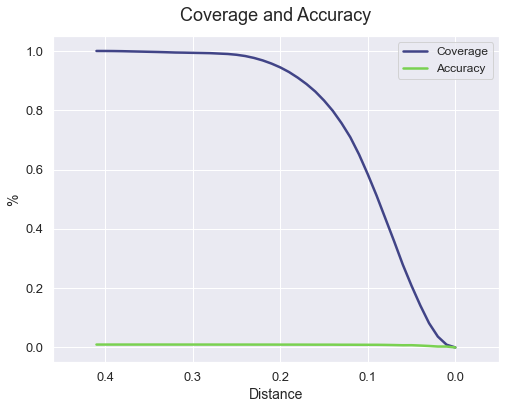

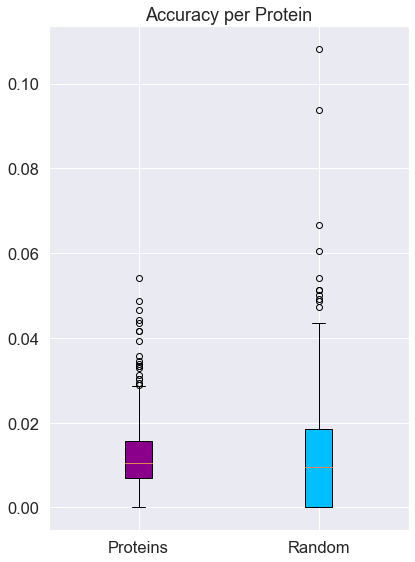

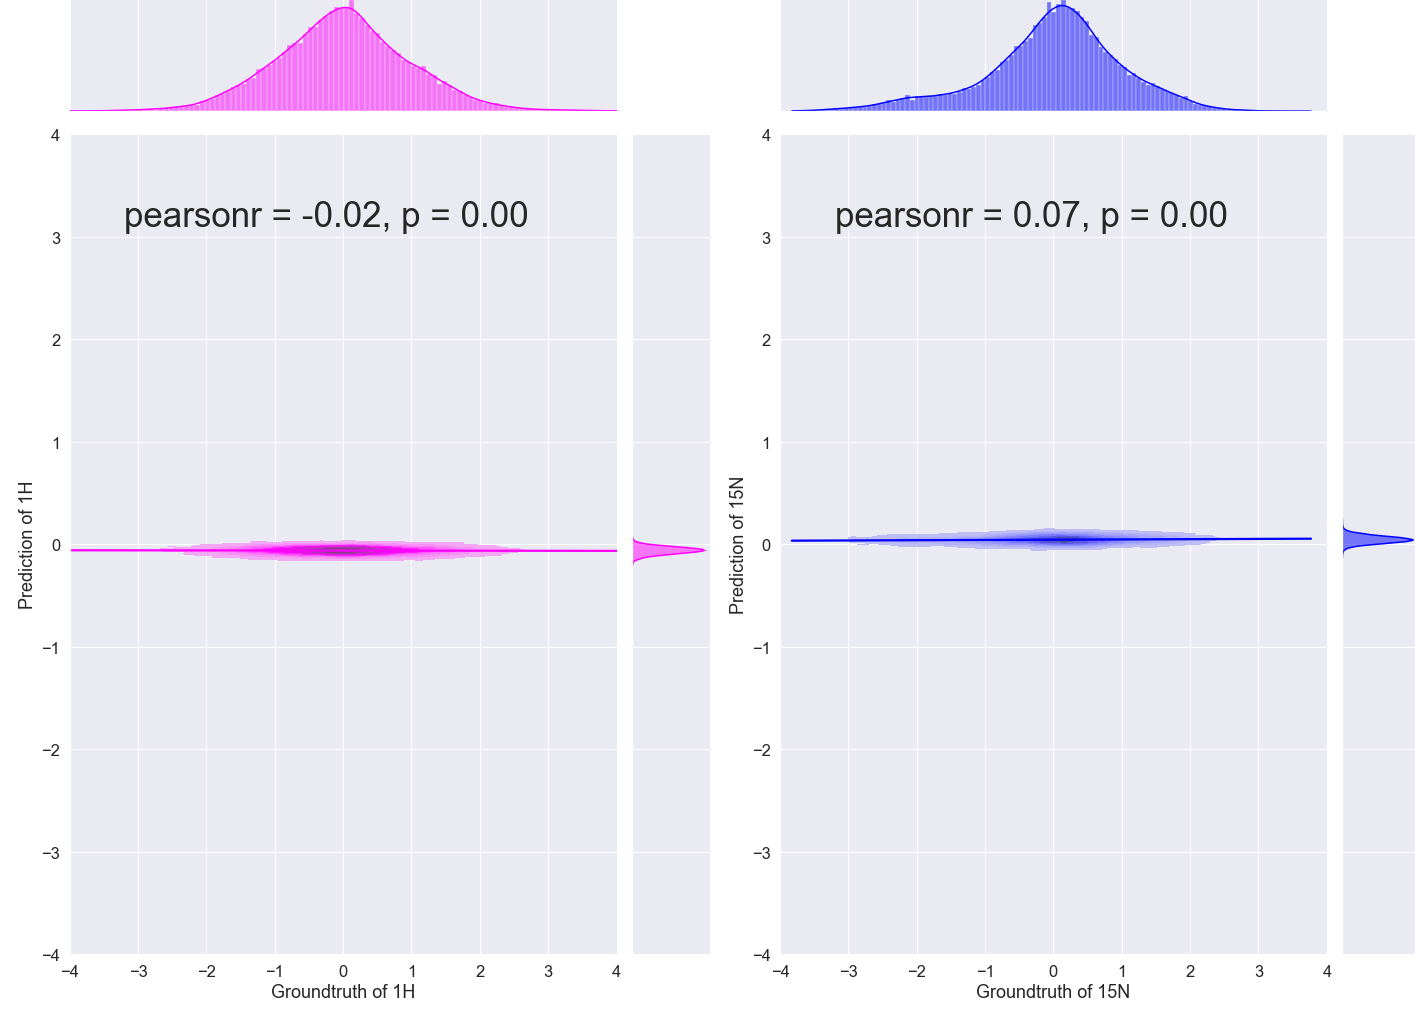

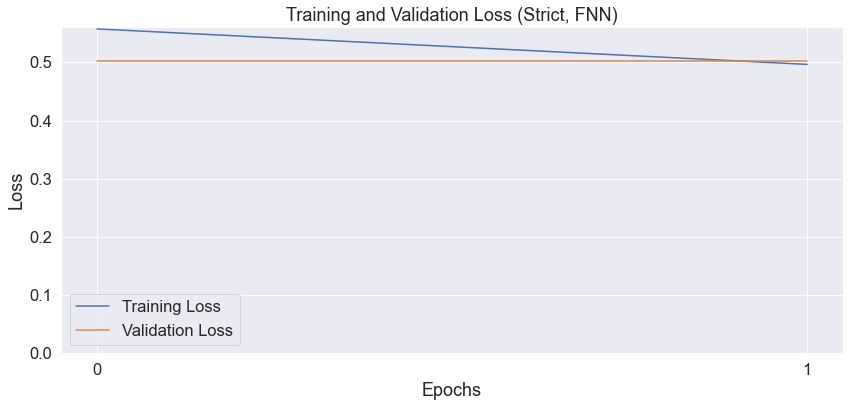

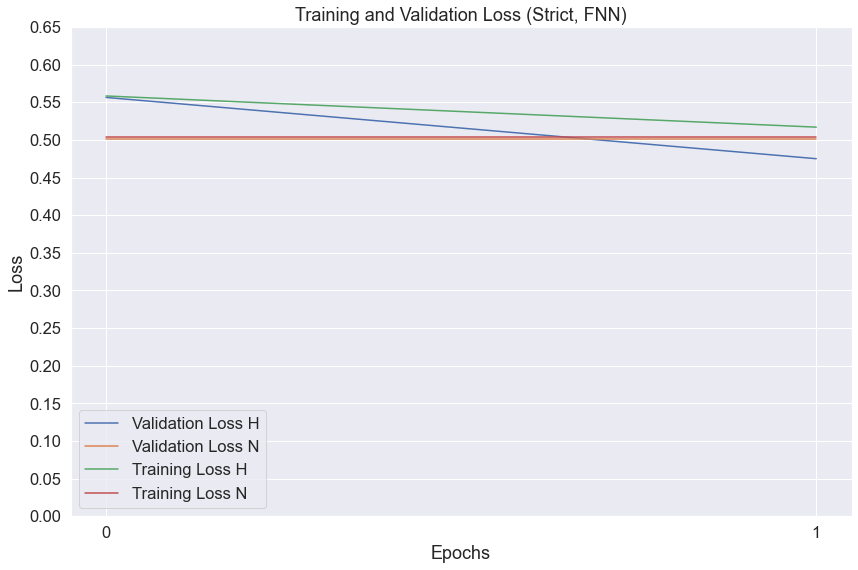

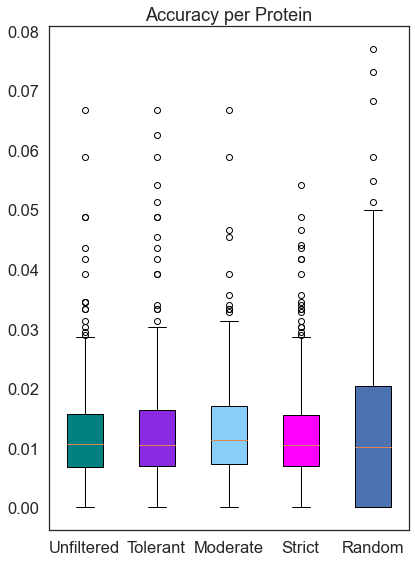

In [142]:
def trainingsets():
    acc_unfiltered, acc_rdnm, pears_unfiltered = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_unfiltered,valid,test,output+"unfiltered/","Unfiltered")

    acc_tolerant, _ , pears_tolerant = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_tolerant,valid,test,output+"tolerant/","Tolerant")


    acc_moderate, _1, pears_moderate = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_moderate,valid,test,output+"moderate/","Moderate") 


    acc_strict, _2, pears_strict = prediction.predict(model_choice, input_dim, hidden_dim, output_dim,
                       batch_size,learning_rate,num_epochs,
                       train_strict,valid,test,output+"strict/","Strict")
    
    
    
    data = [['Unfiltered',round(get_mean(acc_unfiltered),2), round(get_std(acc_unfiltered),2),round(pears_unfiltered[0],2),round(pears_unfiltered[2],2)],
        ['Tolerant',round(get_mean(acc_tolerant),2), round(get_std(acc_tolerant),2),round(pears_tolerant[0],2), round(pears_tolerant[2],2)],
        ['Moderate',round(get_mean(acc_moderate),2), round(get_std(acc_moderate),2),round(pears_moderate[0],2), round(pears_moderate[2],2)],
        ['Strict',round(get_mean(acc_strict),2), round(get_std(acc_strict),2),round(pears_strict[0],2), round(pears_strict[2],2)]]



    df = pd.DataFrame(data, columns=['Dataset', 'Mean of Accuracy', 'Stdv of Accuracy','Pearson Correlation (H)','Pearson Correlation (N)'])
    df.to_csv(output+"acc_pears_table_trainigsets_prostt5_"+model_choice+'_'+str(num_epochs)+'_'+str(learning_rate)+'_'+str(hidden_dim)+".csv",index=False)
    df
    
    data = [acc_unfiltered, acc_tolerant,acc_moderate,acc_strict, acc_rdnm]
    labels = ['Unfiltered','Tolerant','Moderate','Strict','Random']
    colours = ['teal','blueviolet','lightskyblue','magenta']
    
    get_boxplot_accuracy(data,labels,model_choice,num_epochs,learning_rate,hidden_dim,output,'prostt5',colours)
trainingsets()